# **Miniproject 2**
## **~Large~ Small Language Model**

### **Objective**
Implement a transformer-based, character-level language model (GPT-like) and train it on the Shakespeare dataset. By the end of this project, you should be able to generate Shakespearean-like text given a seed string.

You will probably want to train the model on a GPU. You can use free GPUs on [Google Colab](https://colab.research.google.com/?utm_source=scs-index).

### **Dataset**:

The Shakespeare dataset contains the complete works of William Shakespeare, including his plays, poems, and sonnets.

[**Download link**](https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt)

In a character-level language model, each character in the input data is mapped to its respective index from a dictionary. The input to the model is in the form (B, N), where B is the batch size and N is the number of tokens for each sequence. The model was tested with B=N=128, but feel free to explore different values.

An interface for the dataset class that takes care of tokenization is provided below.



```python
from torch.utils.data import Dataset

class CharDataset(Dataset):
    """
    Emits batches of characters.

    Adapted from "https://github.com/karpathy/minGPT".
    """

    def __init__(self, config, data):

        chars = ... # get characters from the input data
        self.stoi = { ch:i for i,ch in enumerate(chars) } # map characters to integer indices

        ...

    def get_vocab_size(self):
        raise NotImplementedError()

    def __len__(self):
        raise NotImplementedError()

    def __getitem__(self, idx):
        # grab a chunk of (block_size + 1) characters from the data
        # encode every character to an integer
        # return the chunk and the shifted version as tensors
        pass
```




### **Requirements**

#### **Architecture**

Implement the Transformer's decoder-only structure.
This includes

* input token embeddings
* the causal multi-head self-attention mechanism
* feed-forward neural networks
* positional encodings, residual connections, layer normalizations.

The project was tested with $12$ layers, $8$ attention heads, and $768$ embedding dimensions, on a single GPU.

The `forward` method for the entire model has the following form:

```
tok_emb = WTE(idx) # token embeddings
pos_emb = WPE(pos) # position embeddings
x = Dropout(tok_emb + pos_emb)
for Block in Blocks:
    x = Block(x)
x = Final_LayerNorm(x)
logits = LM_Head(x)
```

The `forward` method for the transformer block has the following form:



```
x = x + self.CausalSelfAttn(self.LayerNorm_1(x))
out = x + self.MLP(self.LayerNorm_2(x))
```

---

#### **Training**

In a character-level transformer language model, the goal is to predict the next character in a sequence given the previous characters. To train such a model effectively, we use two versions of our data: the input sequence and a shifted version of this sequence, which serves as the target for our predictions.

Preprocess the dataset to a character-level representation.
Use a sliding window approach for sequence chunks (e.g., window size of $128$ characters).
Implement causal masking for the self-attention mechanism.
Use the [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) optimizer and the cross-entropy loss.

**Optional**:

* Implement a learning rate decay strategy
* Implement gradient clipping

---


#### **Evaluation and Inference**

* Monitor the cross-entropy loss. Use a seed string to initialize the model and generate Shakespearean-like text.

* In order to generate the characters, at each generation step you can either select the character with the highest probability, or you can sample according to the output distribution.

The high-level pseudocode for generation is:

```python
model.eval()
with torch.no_grad():
    context = "O God, O God!"
    tokenized_context = tokenize(context)
    # the model should implement a method to generate tokens given a prompt
    y = model.generate(tokenized, ...)
    completion = tokens_to_string(y)
```

**Optional**:
* Compute the [perplexity](https://medium.com/@priyankads/perplexity-of-language-models-41160427ed72#:~:text=Intuitively%2C%20perplexity%20means%20to%20be,loss%20obtained%20from%20the%20model.) metric for quantitative evaluation.

### **Example Outputs**

The following are my outputs after $6000$ steps of training, with the seed string "O God, O God!"



```
O God, O God! neither? unto the base very ears,
As damned with it.

DUKE OF YORK:
Away! Once more, one word.

RICHARD:
Clove, dear so; and therein my son will be
false of woe: if ye seems to be the mother
Of gracious order this time when R going kinsperse eyes,
What dost bewreck her fairer drying tears.

NORTHUMBERLAND:
Have you forgot the Duke of Norfolk, get him to
again; and and agilic: there is my spirit
So maly did must such a marble perfection.

ELBOW:
Come, bring them with oaths, and so deliver
```


### Resources:

* Vaswani et al., "Attention is All You Need": [link](https://arxiv.org/abs/1706.03762)

* Illustrated Transformer by Jay Alammar: [link](https://jalammar.github.io/illustrated-transformer/)

* OpenAI GPT-2 Paper: [link](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

* Deep Learning Course slides on transformers: [link](https://fleuret.org/dlc/materials/dlc-handout-13-3-transformers.pdf)

# Dependencies

In [131]:
import abc
import json
from abc import abstractmethod
from pathlib import Path

import nltk
import numpy as np
import torch
import re
import requests

from nltk.tokenize import PunktTokenizer
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.nn.attention.flex_attention import create_block_mask, and_masks, flex_attention
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from typing import Iterable, TypeVar
from itertools import chain

from tqdm.auto import tqdm

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/Viktor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Implementation

Some interfaces that will be used:

In [3]:
_T = TypeVar('_T')


class Configurable(metaclass=abc.ABCMeta):
    @abstractmethod
    def to_config(self):
        pass
    
    @classmethod
    def from_config(cls: _T, config: dict) -> _T:
        return cls(**config)
    
    def save(self, path: str | Path) -> None:
        config = self.to_config()
        with open(path, 'w') as f:
            json.dump(config, f, indent=2)
    
    @classmethod
    def load(cls: _T, path: str | Path) -> _T:
        with open(path, 'r') as f:
            config = json.load(f)
        
        return cls.from_config(config)

## Tokenization

For tokenization, we will just use Python's built-in `ord` function. We will reserve a fixed tokenizer size, 128 is enough for English text. Character NUL (`0`) will be used for unknown tokens. 

In [113]:
ords = list(range(128))
for o in ords:
    print(f'"{chr(o)}"'.replace('\n', '\\n').replace('\t', '\\t'), end=' ')
    if o and not o % 10:
        print()

" " "" "" "" "" "" "" "" " "\t" "\n" 
" "" "" "" "" "" "" "" 
"" "" "" "" "" "" "" "" "" "" 
"" " " "!" """ "#" "$" "%" "&" "'" "(" 
")" "*" "+" "," "-" "." "/" "0" "1" "2" 
"3" "4" "5" "6" "7" "8" "9" ":" ";" "<" 
"=" ">" "?" "@" "A" "B" "C" "D" "E" "F" 
"G" "H" "I" "J" "K" "L" "M" "N" "O" "P" 
"Q" "R" "S" "T" "U" "V" "W" "X" "Y" "Z" 
"[" "\" "]" "^" "_" "`" "a" "b" "c" "d" 
"e" "f" "g" "h" "i" "j" "k" "l" "m" "n" 
"o" "p" "q" "r" "s" "t" "u" "v" "w" "x" 
"y" "z" "{" "|" "}" "~" "" 

The tokenizer will also provide masking mechanism. We will use `FlexAttention` interface to explore sparse masking later, see Section ??. To enable experiments down the line, we will add the possibility of masking out:

1) Words, as defined by non-`[a-zA-Z0-9]` characters separation
2) Sentences detected by NLTK.

The motivation will be provided later, for now the important information is as follows:
1. We denote non-`[a-zA-Z0-9]` as special tokens
2. We divide the input tokens into "segments". Tokens can attend only within their own segments.
3. Special tokens that serve as segment separators are grouped into their own segment (so any special can attend to every other special)
4. The special token that follows the segment is an exception. It can attend to its segment and to the one segment before.

For example, if we segment by sentences:
`v`
Where `<s1>` and `<s2>` are space characters with name, `<s1>` can attend to any token in `Oh fox!` and `<s2>` can attend to any character in `Why the long face?` and `<s1>`. At the same time, `f` in `Why the long face?` can only attend to `Why the long ` and `<s2>` to preserve causality.

Last remarks: we will always add STX, Start-of-TeXt (`2`) token to the start of the sequence to serve as "sink" token, see StreamingLLM and other research on the significance of this token. Another special token is ETX, End-of-TeXt (`3`), will be added to the end of complete text (end of document).

In [114]:
IS_SPECIAL_REGEX = re.compile(r'[^a-zA-Z0-9]')

class Tokenizer(Configurable):
    def __init__(
            self, 
            vocab_size: int = 128, 
            device: str = 'cpu', 
            segment: str | None = None,  # "sentence", "word" or "sentence+word"
    ):
        self.size = vocab_size
        self.segment = segment if segment is not None else ''
        
        self.is_special = torch.tensor([
            IS_SPECIAL_REGEX.match(f'{chr(o)}') is not None
            for o in ords
        ], dtype=torch.bool, device=device)
        
        self.tokenizer_sent = None
        
        self.segment_sent = False
        self.segment_word = False
        
        self.unk_token = 0
        self.bot_token = 2
        self.eot_token = 3
        self.sep_token = ord(' ')
        
        for segment_type in self.segment.split('+'):
            if segment_type == 'sentence':
                self.tokenizer_sent = PunktTokenizer('english')
                self.segment_sent = True
            if segment_type == 'word':
                self.segment_word = True
    
    @property
    def device(self):
        return self.is_special.device
    
    def to(self, device: str):
        self.is_special = self.is_special.to(device)
        return self
    
    def to_config(self):
        return {
            'size': self.size,
            'segment': self.segment,
        }
        
    def encode(self, text: str, *, add_sink: bool = True) -> dict:
        if self.segment_sent:
            segments = self.tokenizer_sent.span_tokenize(text)
        else:
            segments = [(0, len(text))]
        
        tokens = list(map(ord, text))
        
        token_segments = []
        segment_mask = []
        segment_starts = []
        
        prev_segm = None
        for segm in segments: 
            start, end = segm
            
            if prev_segm is None:
                if add_sink:
                    # add sink
                    token_segments.append([self.bot_token])
                    segment_mask.append([False])
            elif prev_segm[1] == start:
                # separate the sentences    
                token_segments.append([self.sep_token])
                segment_mask.append([False])
            else:
                prev_start, prev_end = prev_segm
                
                # everything between the sentences
                token_segments.append(tokens[prev_end:start])
                segment_mask.append([False] * (start - prev_end))
            
            token_segments.append(tokens[start:end])
            segment_mask.append([True] * (end - start))
            segment_starts.append(start)
            prev_segm = segm
        
        final_s, final_e = prev_segm
        if final_e != len(tokens):
            token_segments.append(tokens[final_e:len(tokens)])
            segment_mask.append([False] * (len(tokens) - final_e))
            
        all_tokens = chain.from_iterable(token_segments)
        all_segment_mask = chain.from_iterable(segment_mask)
        
        tokens_torch = torch.tensor(list(all_tokens), device=self.device, dtype=torch.int)
        tokens_torch[tokens_torch >= self.size] = self.unk_token
        
        return {
            'tokens': tokens_torch,
            'segment_mask': torch.tensor(list(all_segment_mask), device=self.device, dtype=torch.bool),
            'specials_mask': self.is_special[tokens_torch],
            'segment_starts': torch.tensor(segment_starts, device=self.device, dtype=torch.int),
        }
        
    def decode(self, tokens: Iterable[int]) -> str:
        # skip sink and pad tokens
        return ''.join(chr(o) for o in tokens if o != self.bot_token)
        

IS_SPECIAL_REGEX.match(f'{chr(33)}'), chr(33), IS_SPECIAL_REGEX.match(f'{chr(49)}'), chr(49)

(<re.Match object; span=(0, 1), match='!'>, '!', None, '1')

In [115]:
Tokenizer().is_special

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False, False,
        False, False, False, False, False, False, False, False,  True,  True,
         True,  True,  True,  True,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False,  True,  True,  True,  True,  True,  True, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True,  True,  True,  True,  True])

In [116]:
Tokenizer(segment='sentence').encode('I am a token. You are a token...........  So what?')

{'tokens': tensor([  2,  73,  32,  97, 109,  32,  97,  32, 116, 111, 107, 101, 110,  46,
          32,  89, 111, 117,  32,  97, 114, 101,  32,  97,  32, 116, 111, 107,
         101, 110,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  32,
          32,  83, 111,  32, 119, 104,  97, 116,  63], dtype=torch.int32),
 'segment_mask': tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True, False,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True, False, False,  True,  True,  True,  True,  True,  True,  True,
          True]),
 'specials_mask': tensor([ True, False,  True, False, False,  True, False,  True, False, False,
         False, False, False,  True,  True, False, False, False,  True, False,
         False, False,  True, False,  True, False, False, False, False, Fa

# Pretokenize the datasets

## Shakespear

In [117]:
download_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
response = requests.get(download_url)

file_path = 'tinyshakespeare_input.txt'
with open(file_path, 'wb') as file:
    file.write(response.content)

In [118]:
with open(file_path, 'r') as file:
    content = file.read()

tokenizer = Tokenizer(segment='sentence')
tokenized = tokenizer.encode(content, add_sink=False)

In [119]:
data_path = Path('data')
data_path.mkdir(exist_ok=True)

path = data_path / 'tinyshakespeare'
path.mkdir(exist_ok=True)

np_tokens = tokenized['tokens'].numpy().astype(np.uint8)
np_segment_mask = tokenized['segment_mask'].numpy().astype(bool)
np_special_mask = tokenized['specials_mask'].numpy().astype(bool)
np_segment_starts = tokenized['segment_starts'].numpy().astype(int)

len(np_tokens)

1115394

In [120]:
n_sent = len(np_segment_starts)
n_train_sent = int(n_sent * 0.95)
n_val_sent = n_sent - n_train_sent
n_train_sent, n_val_sent

(11837, 623)

In [121]:
np_segment_ends = np.roll(np_segment_starts, -1)
np_segment_ends[-1] = len(np_tokens)
segm_len = np_segment_ends - np_segment_starts

n_train_tokens = int(segm_len[:n_train_sent].sum())
n_val_tokens = len(np_tokens) - n_train_tokens
n_train_tokens, n_val_tokens

(1070080, 45314)

In [122]:
train_token_mask = torch.concat([
    torch.ones(n_train_tokens, dtype=torch.bool), 
    torch.zeros(n_val_tokens, dtype=torch.bool)
])
val_token_mask = ~train_token_mask

train_sent_mask = torch.concat([
    torch.ones(n_train_sent, dtype=torch.bool), 
    torch.zeros(n_val_sent, dtype=torch.bool)
])
val_sent_mask = ~train_sent_mask

np_tokens_train = np_tokens[train_token_mask]
np_segment_mask_train = np_segment_mask[train_token_mask]
np_special_mask_train = np_special_mask[train_token_mask]
np_segment_starts_train = np_segment_starts[train_sent_mask]

np_tokens_val = np_tokens[val_token_mask]
np_segment_mask_val = np_segment_mask[val_token_mask]
np_special_mask_val = np_special_mask[val_token_mask]
np_segment_starts_val = np_segment_starts[val_sent_mask]

In [123]:
train_path = path / 'train'
train_path.mkdir(exist_ok=True)

np.save(train_path / 'tokens.npy', np_tokens_train)
np.save(train_path / 'segment_mask.npy', np_segment_mask_train)
np.save(train_path / 'special_mask.npy', np_special_mask_train)
np.save(train_path / 'segment_starts.npy', np_segment_starts_train)

In [124]:
val_path = path / 'val'
val_path.mkdir(exist_ok=True)

np.save(val_path / 'tokens.npy', np_tokens_val)
np.save(val_path / 'segment_mask.npy', np_segment_mask_val)
np.save(val_path / 'special_mask.npy', np_special_mask_val)
np.save(val_path / 'segment_starts.npy', np_segment_starts_val)

## FineWeb Edu

In [125]:
# TODO

## Pretokenized dataset loader

In [126]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, path: str | Path, *, start_token: int, target_length: int):
        path = Path(path)
        assert path.exists() and path.is_dir()
        
        tokens_path = path / 'tokens.npy'
        segment_mask = path / 'segment_mask.npy'
        special_mask = path / 'special_mask.npy'
        segment_starts = path / 'segment_starts.npy'
        
        self.start_token = start_token
        self.target_length = target_length
        
        self.tokens = np.memmap(tokens_path, dtype=np.uint8, mode='r')
        self.segment_mask = np.memmap(segment_mask, dtype=np.uint8, mode='r')
        self.special_mask = np.memmap(special_mask, dtype=np.uint8, mode='r')
        self.segment_starts = np.load(segment_starts)
        
    def __len__(self):
        return len(self.segment_starts)
    
    def __getitem__(self, idx):
        start_idx = self.segment_starts[idx]
        end_idx = start_idx + self.target_length - 1  # reserve one token for start_token
        
        tokens = torch.tensor(self.tokens[start_idx:end_idx].astype(int))
        segment_mask = torch.tensor(self.segment_mask[start_idx:end_idx])
        special_mask = torch.tensor(self.special_mask[start_idx:end_idx])
        
        return {
            'tokens': torch.concatenate([torch.tensor([self.start_token]), tokens]),
            'segment_mask': torch.concatenate([torch.tensor([False]), segment_mask]),
            'special_mask': torch.concatenate([torch.tensor([True]), special_mask])
        }
        
Dataset('data/tinyshakespeare/train', start_token=2, target_length=10)[100]

{'tokens': tensor([  2, 100,  32, 109,  97, 107, 101,  32,  98, 111]),
 'segment_mask': tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.uint8),
 'special_mask': tensor([1, 0, 1, 0, 0, 0, 0, 1, 0, 0], dtype=torch.uint8)}

# FlexAttention masking and Collator

In [52]:
def calculate_intervals(boundary_mask):
    # Find cumulative sum of the gaps to identify different intervals
    interval_idx = torch.cumsum(boundary_mask, dim=-1) + 1
    shifted = interval_idx.roll(1)
    shifted[:, 0] = interval_idx[:, 0]
    
    return shifted


def get_interval_block_mask(interval_mask, *, max_distance: int = 0):
    boundary_mask = ~interval_mask
    interval_idx = calculate_intervals(boundary_mask)
    
    def interval_block_mask(b, h, q_idx, kv_idx):
        # can only attend to tokens in the same interval
        # or boundaries between intervals
        return (
                boundary_mask[b, kv_idx] 
                | (q_idx - kv_idx < max_distance) 
                | (interval_idx[b, q_idx] == interval_idx[b, kv_idx])
        )
    
    return interval_block_mask


def get_padding_block_mask(tokens, *, padding_token):
    
    def padding_block_mask(b, h, q_idx, kv_idx):
        # nothing can attend to padding tokens and padding tokens cannot attend to anything
        return (tokens[b, kv_idx] != padding_token) & (tokens[b, q_idx] != padding_token)
    
    return padding_block_mask


def causal_block_mask(b, h, q_idx, kv_idx):
    # can only attend to past tokens and self
    return q_idx >= kv_idx


class Collator:
    def __init__(
            self, 
            padding_token: int, 
            mask_words: bool = False, 
            mask_segments: bool = False
    ):
        self.padding_token = padding_token
        self.mask_words = mask_words
        self.mask_segments = mask_segments
    
    def __call__(self, batch):
        masks = [causal_block_mask]
        
        # Extract each element type in the batch
        tokens = [item['tokens'] for item in batch]
        
        if self.mask_segments:
            segment_mask = [item['segment_mask'] for item in batch]
            segment_mask_padded = pad_sequence(segment_mask, batch_first=True, padding_value=0)
            masks.append(get_interval_block_mask(segment_mask_padded))
        
        if self.mask_words:
            specials_mask = [item['specials_mask'] for item in batch]
            specials_mask_padded = pad_sequence(specials_mask, batch_first=True, padding_value=0)
            masks.append(get_interval_block_mask(~specials_mask_padded))
        
        # Pad tokens with the specified padding token index
        tokens_padded = pad_sequence(tokens, batch_first=True, padding_value=self.padding_token)
        masks.append(get_padding_block_mask(tokens, padding_token=self.padding_token))
        
        # Determine batch and sequence dimensions
        batch_size, seq_length = tokens_padded.size()
        
        # Create causal block mask using FlexAttention's create_block_mask function
        block_mask = create_block_mask(
            mask_mod=and_masks(masks),  # Causal mask function
            B=batch_size,
            H=1,                        # Number of heads; adjust if using multi-head attention
            Q_LEN=seq_length,
            KV_LEN=seq_length,
            device=tokens_padded.device
        )
        
        # Create final batch dictionary
        batch_dict = {
            'tokens': tokens_padded,
            'block_mask': block_mask    # Add block mask to the batch
        }
        
        return batch_dict


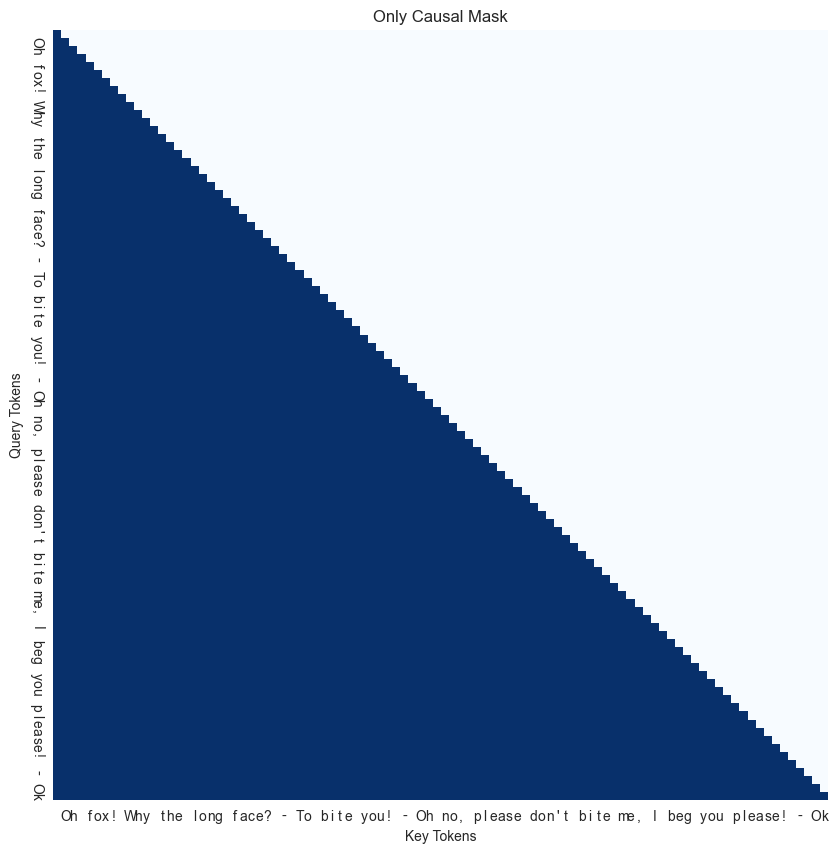

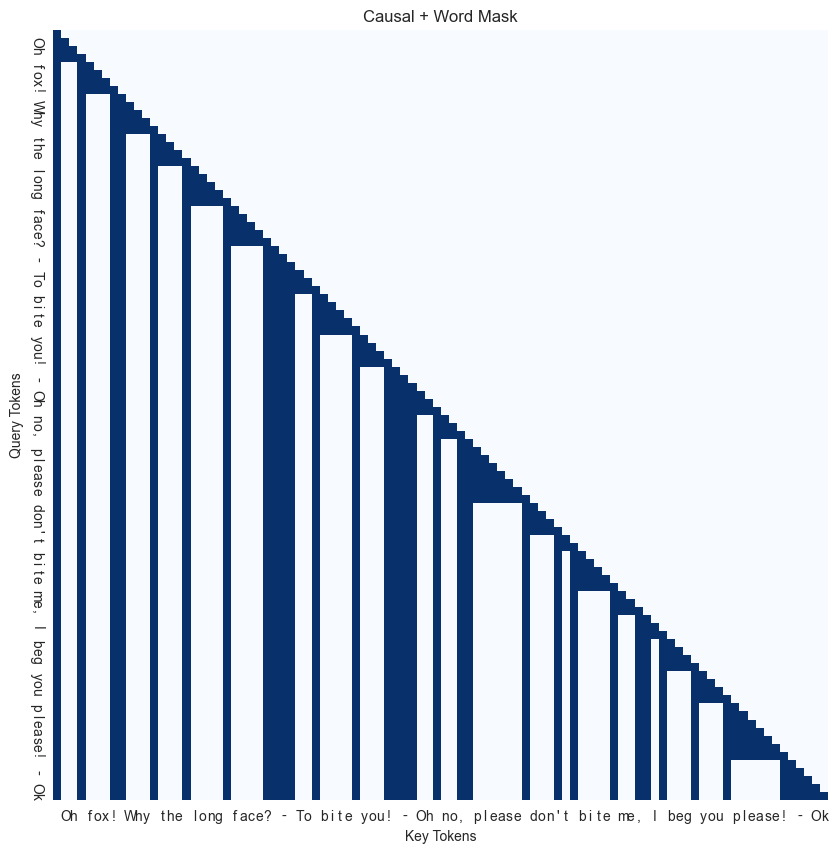

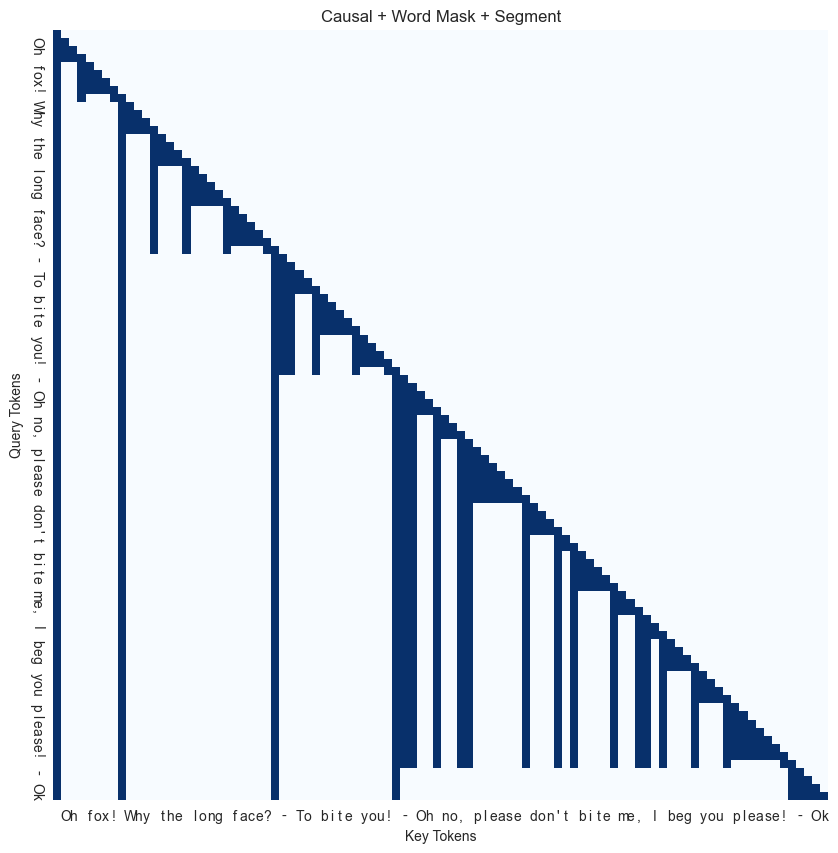

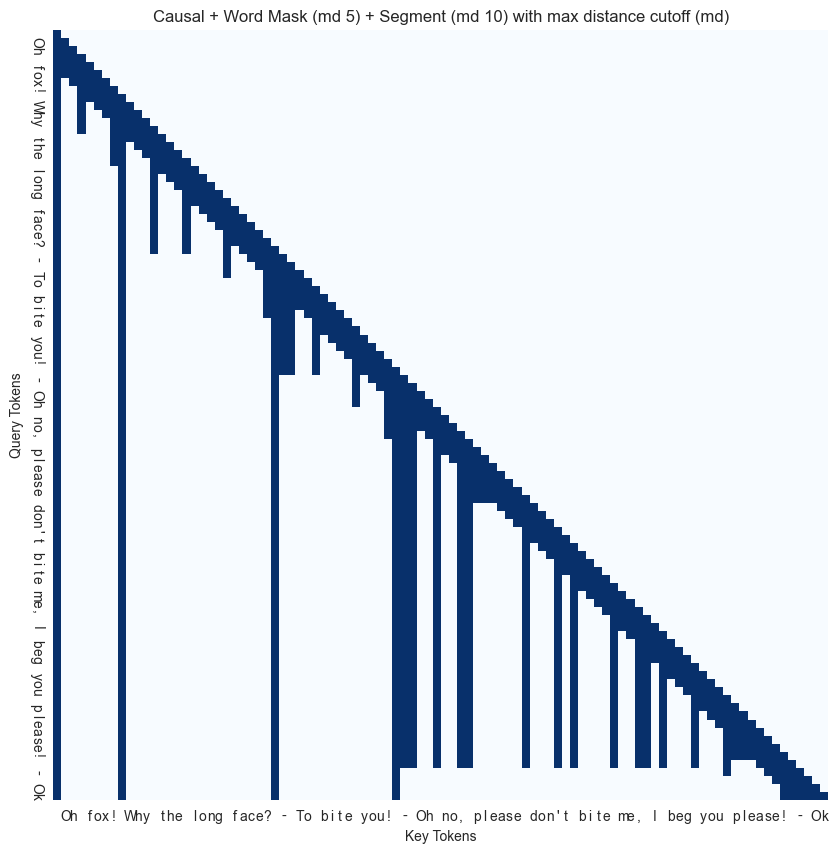

In [127]:
def visualize_mask(mask, text, title=""):
    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(
        mask.numpy(), 
        cmap="Blues", 
        cbar=False, 
        annot=False, 
        xticklabels=[c for c in [' ', *text]], 
        yticklabels=[c for c in [' ', *text]],
    )
    plt.yticks(rotation=270)
    plt.xticks(rotation=0)
    plt.title(title)
    plt.xlabel("Key Tokens")
    plt.ylabel("Query Tokens")
    plt.show()
    
    
text = "Oh fox! Why the long face? - To bite you! - Oh no, please don't bite me, I beg you please! - Ok"

# visualize different combinations of masks
# 1) only causal
# 2) with word masking
# 3) with segment masking
# 4) with both word and segment masking
tokenizer_simple = Tokenizer()
tokenizer_sentence = Tokenizer(segment='sentence')

tokens = tokenizer_simple.encode(text)['tokens'].unsqueeze(0)
segment_mask_word = ~tokenizer_simple.encode(text)['specials_mask'].unsqueeze(0)
segment_mask_sentence = tokenizer_sentence.encode(text)['segment_mask'].unsqueeze(0)
seq_length = len(tokens[0])

# 1) Only causal mask
block_mask_causal = torch.zeros((seq_length, seq_length), dtype=torch.bool)
for q in range(seq_length):
    for kv in range(seq_length):
        block_mask_causal[q, kv] = causal_block_mask(0, 0, q, kv)
visualize_mask(block_mask_causal, text, title="Only Causal Mask")

# 2) Causal + Word Mask
interval_mask_word = get_interval_block_mask(segment_mask_word)
block_mask_word = torch.zeros((seq_length, seq_length), dtype=torch.bool)
for q in range(seq_length):
    for kv in range(seq_length):
        causal = causal_block_mask(0, 0, q, kv)
        interval = interval_mask_word(0, 0, q, kv)
        block_mask_word[q, kv] = causal & interval
visualize_mask(block_mask_word, text, title="Causal + Word Mask")

# 2) Causal + Word Mask + Segment
interval_mask_segment = get_interval_block_mask(segment_mask_sentence)
block_mask_word = torch.zeros((seq_length, seq_length), dtype=torch.bool)
for q in range(seq_length):
    for kv in range(seq_length):
        causal = causal_block_mask(0, 0, q, kv)
        interval = interval_mask_word(0, 0, q, kv)
        segment = interval_mask_segment(0, 0, q, kv)
        block_mask_word[q, kv] = causal & interval & segment
visualize_mask(block_mask_word, text, title="Causal + Word Mask + Segment")

# 2) Causal + Word Mask + Segment with max distance cutoff
interval_mask_word = get_interval_block_mask(segment_mask_word, max_distance=5)
interval_mask_segment = get_interval_block_mask(segment_mask_sentence, max_distance=10)
block_mask_word = torch.zeros((seq_length, seq_length), dtype=torch.bool)
for q in range(seq_length):
    for kv in range(seq_length):
        causal = causal_block_mask(0, 0, q, kv)
        interval = interval_mask_word(0, 0, q, kv)
        segment = interval_mask_segment(0, 0, q, kv)
        block_mask_word[q, kv] = causal & interval & segment
visualize_mask(block_mask_word, text, title="Causal + Word Mask (md 5) + Segment (md 10) with max distance cutoff (md)")

# Performance comparison depending on the sparsity level (H100 GPU, Shakespear texts)

By length

In [130]:
n_trials = 100
hidden_dim = 1024
emb = nn.Embedding(128, 1024)

In [ ]:
min_len_log2 = 4
max_len_log2 = 50

for length_log2 in tqdm(range(min_len_log2, max_len_log2), total=max_len_log2 - min_len_log2):
    length = 2**length_log2
    dataset = Dataset('data/tinyshakespeare/train', start_token=2, target_length=length)
    loader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=8)
    
    batches = [next(loader) for _ in range(n_trials)]
    flex_attention()

# Model

Llama-like architecture without GQA.

In [10]:
class LLM(nn.Module):
    pass

# Training

In [ ]:
from torch.utils.data import Dataset

class CharDataset(Dataset):
    """
    Emits batches of characters.

    Adapted from "https://github.com/karpathy/minGPT".
    """

    def __init__(self, config, data):

        chars = ... # get characters from the input data
        self.stoi = { ch:i for i,ch in enumerate(chars) } # map characters to integer indices

        ...

    def get_vocab_size(self):
        raise NotImplementedError()

    def __len__(self):
        raise NotImplementedError()

    def __getitem__(self, idx):
        # grab a chunk of (block_size + 1) characters from the data
        # encode every character to an integer
        # return the chunk and the shifted version as tensors
        pass

In [ ]:
def train(model, dataset, **kwargs):
    pass